In [2]:
# run only if you have not installed the next libraries
!pip install numpy
!pip install matplotlib
!pip install scipy
!pip install getdist

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate as sci
import time
import pip
from getdist import plots, MCSamples
%matplotlib inline

In [79]:
def likelihood(mod, dat, sigma): # retorna escalar, log(L)
    sig = np.diagonal(sigma)
    L = -0.5*chi2(mod, dat, sigma)[0]  + np.sum(-0.5*np.log(2*np.pi*sig**2))
    #pp = np.argwhere((a1==-np.inf))
    #a1[pp] = 0
    return L


def chi2(mod, dat, sigma):
    sig = np.diagonal(sigma)
    AA = np.sum(((dat - mod)/sig)**2)
    BB = np.sum((dat - mod)/sig**2)	
    CC = np.sum(1/sig**2)
    chi = AA - (BB**2)/CC
    return chi, BB/CC


def prior(theta): # vector de parametros anterior y posterior
    ct = 1
    r = np.diag(np.ones(len(theta))*ct)
    p = -0.5*np.log(np.linalg.det(2*np.pi*r)) + -0.5*theta.dot((np.linalg.inv(r)).dot(theta)) 
    return p


def acepta_mh(T1, pos1, T2, pos2, m1, m2):
    alpha = min(pos2 - pos1, 0) # log(alpha)
    u = np.log(np.random.uniform())
    if u<alpha:
        return T2, pos2, m2
    else:
        return T1, pos1, m1


def EHubble(theta, z): # parametro de hubble
    om0 = theta[0]
    ol = theta[1]
    w = theta[2]
    arg = om0*(1 + z)**3 + (1 - om0 - ol)*(1 + z)**2 + ol*(1 + z)**(3*(1 + w))
    EE = np.sqrt(arg)
    return EE, arg


def modelo(theta,z): # modulo de la distancia teorico
    om0 = theta[0]
    ol = theta[1]
    omega_k = 1 - om0 - ol
    E = EHubble(theta, z)[0]
    I = sci.cumtrapz(1/(E + 1e-300), z, initial=0)+z[0]*((1/(E + 1e-300))[0] + 1)/2 # estabilidad numerica
    o_k_s = np.sqrt(abs(omega_k))
    if omega_k==0:
        dl = (1 + z)*I
    elif omega_k<0:
        dl = (1 + z)*np.sin(o_k_s*I)/(o_k_s + 1e-300) # estabilidad numerica
    elif omega_k>0:	
        dl = (1 + z)*np.sinh(o_k_s*I)/(o_k_s + 1e-300) # estabilidad numerica
    dist = 5*np.log10(dl + 1e-300) # estabilidad numerica
    #f (-np.inf==dist).any(): 
    #    print(theta)
    return dist


def tasa(tant, tpos):
    l = len(tant)
    if np.sum(tant==tpos)==l:
        c = 0
    else:
        c = 1
    return c


def revisa(theta, z):
    arg = EHubble(theta, z)[1]
    bol = np.sum(arg<0)
    if bol>0:
        a = 0
    else:
        a = 1
    return a


def argmin2(t1, t2, t3, V): # busca en base a vector chi2 y devulve minimos de los parametros	
    amin = np.argmin(V)
    return t1[amin], t2[amin], t3[amin]


def revisa1(X):
    x = X[0]
    y = X[1]
    z = X[2]
    xlim = np.array([0, 1])
    ylim = xlim
    zlim = np.array([-np.inf, 1/3])
    if xlim[0]<x<xlim[1] and ylim[0]<y<ylim[1] and zlim[0]<z<zlim[1]:
        return 1
    else:
        return 0
    

def MH(modelo, datos, N, params, q0, cov_mod, cov_prop, des=0.24):
    """
    datos: X, F(X)
    params: ['p1', 'p2', ..., 'pn']
    cov: matriz de covarianza de datos
    """
    # Matrices de datos de la cadena
    #pid = PID(kp=10, ki=10, kd=10, o_min=2, o_max=20)
    T0 = q0
    X = datos[0]
    Y = datos[1]
    chain = [] 
    post = [] 
    chi_2 = []
    Ratio = []
    mod = []
    acept = 0
    mod0 = modelo(T0, X)
    chi0 = chi2(mod0, Y, cov_mod)[0]
    pos0 = likelihood(mod0, Y, cov_mod) + prior(T0)
    mod.append(mod0)
    chain.append(T0)
    post.append(pos0)
    chi_2.append(chi0)
    Ratio.append(100)

    # pasos de cadena
    Ti = time.time()
    for i in range(N):
        # revisa si se paso umbral de burn in
        """	
        if chi_2[i]<=580 and d==0 and o!=0:
            covarianza = COV[o]
            d = 1
            print('actualizada')
            print(covarianza)
        """	
        # selecciona ultimo elemento de la cadena
        T0 = chain[i]
        # itera hasta que encuentra un proposal valido
        while True:
            T1 = np.random.multivariate_normal(mean=T0, cov=cov_prop)
            if revisa1(T1):
                break
        # selecciona ultimo modelo
        mod0 = mod[i]
        # calcula modelo con proposal
        mod1 = modelo(T1, X)
        # selecciona ultima dis. post.
        pos0 = post[i]
        # calcula nueva dist. post.
        pos1 = likelihood(mod1, Y, cov_mod) + prior(T1)
        # decision de aceptacion
        A = acepta_mh(T0, pos0, T1, pos1, mod1, mod1)
        # guarda la variable aceptada (puede ser la anterior o proposal)
        chain.append(A[0])
        post.append(A[1])
        mod.append(A[2])
        chi_2.append(chi2(A[2], Y, cov)[0])
        # ratio de aceptacion
        acept += tasa(chain[i], chain[i + 1]) 
        Ratio.append(acept/(i+1)*100)
        if i%100==0:
            print(i)
            print('ratio', Ratio[i])

    Tf = time.time()
    print('Tiempo cadena', np.around(Tf - Ti, 0), 's')
    
    ratio = acept/N*100
    print('ratio %', np.rint(ratio))

    post = np.array(post)
    chain = np.array(chain)
    chi_2 = np.array(chi_2)
    Ratio = np.array(Ratio)
  
    t1 = chain[:,0]
    t2 = chain[:,1]
    t3 = chain[:,2]

    # busca argumento del minimo de chi2
    t1m, t2m, t3m = np.around(argmin2(t1, t2, t3, chi_2),3)
    mins = [t1m, t2m, t3m]
    muestras = {}
    for i in range(len(params)):
        muestras[params[i]] = chain[:, i]
    return muestras, Ratio, chi_2, post, mins

In [5]:
# install('getdist')

# saved things directory
direc = '/home/mauricio/Documents/Uni/Intro_2/' + 'gal.txt'

# Carga de datos
redshift = np.genfromtxt('gal.txt', usecols=(1))
mu_obs = np.genfromtxt('gal.txt', usecols=(2)) # m - M
cov = np.genfromtxt('gal.txt', usecols=(3))

p = np.argsort(redshift)
redshift = redshift[p]
mu_obs = mu_obs[p]
cov = cov[p]
cov = np.diag(cov)


In [80]:
# configuracion cadena

# params
labs = [r'$\Omega_{m}$', r'$\Omega_{\Lambda}$', r'w']
labs1 = [r'\Omega_{m}', r'\Omega_{\Lambda}', r'w']

# covarianza inicial
cov_ini = np.diag(np.array([0.4, 1.125, 4])**2)*0.5e-2

In [83]:
q0 = np.array([0.5, 0.4, -2]) # np.random.uniform(low=[0,0,-5], high=[1, 1, 1/3], size=3)
print('q0', q0)
R = MH(modelo, [redshift, mu_obs], N=20000, params=['om', 'ol', 'w'], q0=q0, cov_mod=cov, cov_prop=cov_ini)


q0 [ 0.5  0.4 -2. ]
0
ratio 100
100
ratio 26.0
200
ratio 28.499999999999996
300
ratio 26.333333333333332
400
ratio 27.0
500
ratio 27.200000000000003
600
ratio 27.833333333333332
700
ratio 28.857142857142858
800
ratio 28.625
900
ratio 29.555555555555557
1000
ratio 30.099999999999998
1100
ratio 29.63636363636364
1200
ratio 29.833333333333336
1300
ratio 30.153846153846153
1400
ratio 30.214285714285715
1500
ratio 29.46666666666667
1600
ratio 29.25
1700
ratio 28.58823529411765
1800
ratio 28.444444444444443
1900
ratio 28.47368421052632
2000
ratio 28.4
2100
ratio 28.42857142857143
2200
ratio 28.136363636363637
2300
ratio 27.956521739130437
2400
ratio 27.583333333333332
2500
ratio 27.200000000000003
2600
ratio 26.923076923076923
2700
ratio 27.0
2800
ratio 26.89285714285714
2900
ratio 26.344827586206897
3000
ratio 26.633333333333333
3100
ratio 26.225806451612904
3200
ratio 26.09375
3300
ratio 26.181818181818183
3400
ratio 26.205882352941178
3500
ratio 25.97142857142857
3600
ratio 25.61111111111

Text(0,0.5,'$\\Omega_{\\Lambda}$')

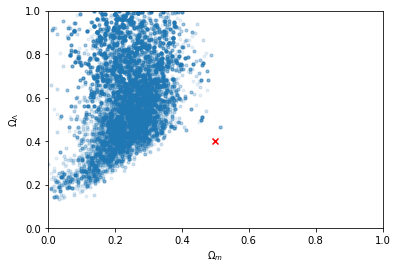

In [84]:
plt.scatter(R[0]['om'], R[0]['ol'], marker='.', alpha=0.1)
plt.scatter(R[0]['om'][0], R[0]['ol'][0], marker='x', color='red', alpha=1)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel(r'$\Omega_{m}$')
plt.ylabel(r'$\Omega_{\Lambda}$')

Text(0,0.5,'$\\omega$')

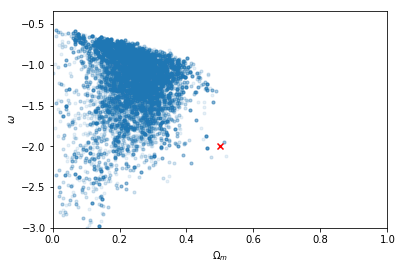

In [85]:
plt.scatter(R[0]['om'], R[0]['w'], marker='.', alpha=0.1)
plt.scatter(R[0]['om'][0], R[0]['w'][0], marker='x', color='red', alpha=1)
plt.xlim([0, 1])
plt.ylim([-3, -1/3])
plt.xlabel(r'$\Omega_{m}$')
plt.ylabel(r'$\omega$')

Text(0,0.5,'$\\omega$')

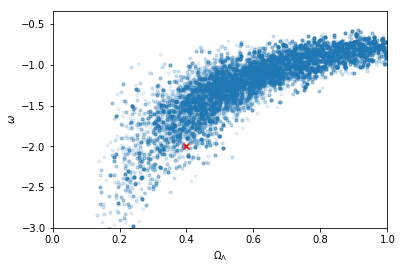

In [86]:
plt.scatter(R[0]['ol'], R[0]['w'], marker='.', alpha=0.1)
plt.scatter(R[0]['ol'][0], R[0]['w'][0], marker='x', color='red', alpha=1)
plt.xlim([0, 1])
plt.ylim([-3, -1/3])
plt.xlabel(r'$\Omega_{\Lambda}$')
plt.ylabel(r'$\omega$')

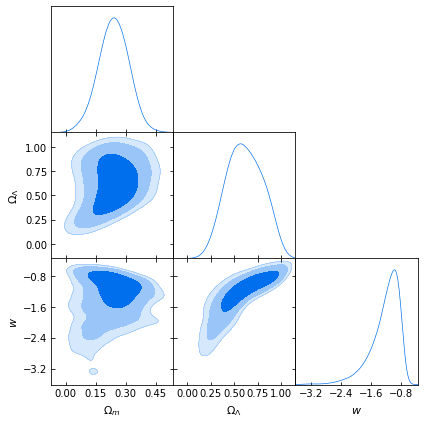

In [87]:
#Get the getdist MCSamples objects for the samples, specifying same parameter
#names and labels; if not specified weights are assumed to all be unity

ndim = 3
names = ["x%s"%i for i in range(ndim)]
labels = ["x_%s"%i for i in range(ndim)]
t1 = R[0]['om']
t2 = R[0]['ol']
t3 = R[0]['w']
samps = np.vstack((t1, t2, t3)).T
samples = MCSamples(samples=samps, names=labs1, labels=labs1)

#Triangle plot
g = plots.getSubplotPlotter()
samples.updateSettings({'contours': [0.68, 0.95, 0.99]})
g.settings.num_plot_contours = 3
g.triangle_plot([samples], filled=True)
